In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

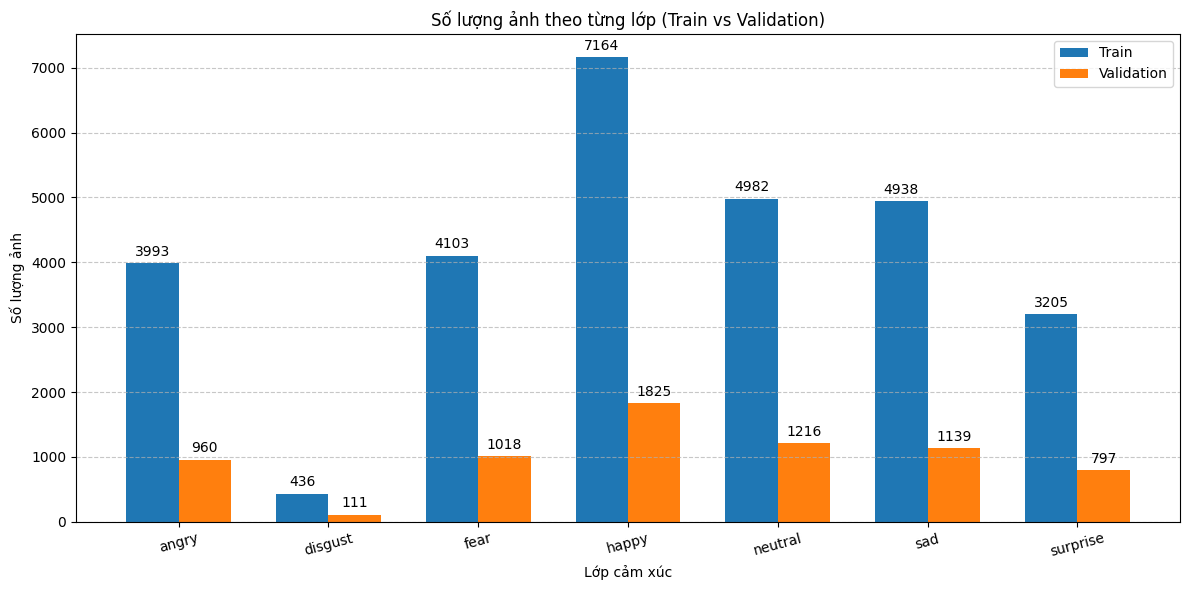

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn
train_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/train'
val_dir = 'D:/DatasetDoAnCoSO/dataset_emotion/images/validation'

# Lấy danh sách lớp
classes = os.listdir(train_dir)
train_counts = []
val_counts = []

# Đếm ảnh
for cls in classes:
    train_path = os.path.join(train_dir, cls)
    val_path = os.path.join(val_dir, cls)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    val_count = len(os.listdir(val_path)) if os.path.exists(val_path) else 0

    train_counts.append(train_count)
    val_counts.append(val_count)

# Vẽ biểu đồ
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

ax.set_ylabel('Số lượng ảnh')
ax.set_xlabel('Lớp cảm xúc')
ax.set_title('Số lượng ảnh theo từng lớp (Train vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=15)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị số lượng trên đầu mỗi cột
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 điểm pixel lên trên
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [16]:
emotion_labels = sorted(os.listdir(train_dir))
print("Các thư mục nhãn có trong train_dir:")
print(emotion_labels)

for label in emotion_labels:
    label_path = os.path.join(train_dir, label)
    print(f"{label}: {len(os.listdir(label_path))} ảnh")

Các thư mục nhãn có trong train_dir:
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
angry: 3993 ảnh
disgust: 436 ảnh
fear: 4103 ảnh
happy: 7164 ảnh
neutral: 4982 ảnh
sad: 4938 ảnh
surprise: 3205 ảnh


In [17]:
import pathlib
from pathlib import Path
import numpy as np

# Đường dẫn thư mục train và validation
train_dir = pathlib.Path('D:/DatasetDoAnCoSO/dataset_emotion/images/train')

image_count = len(list(train_dir.glob('*/*.png')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

0
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
7


In [18]:
val_dir = pathlib.Path('D:/DatasetDoAnCoSO/dataset_emotion/images/validation')
BATCH_SIZE = 32             # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 227            # input Shape required by the model
IMG_WIDTH = 227             # input Shape required by the model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# Rescalingthe pixel values from 0~255 to 0~1 For RGB Channels of the image.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# training_data for model training
train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))
class_mode = 'categorical' # for multi-class classification

val_data_gen = image_generator.flow_from_directory(directory=str(val_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))
class_mode = 'categorical' # for multi-class classification



Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [19]:
model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
  tf.keras.layers.Dropout(0.2),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  tf.keras.layers.Dropout(0.2),
    # 6th Conv
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
    # add dropout 0.5 ==> tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])
#Tóm tắt mô hình
model.summary()


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 256)    │     2,973,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 27, 27, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 27, 27, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 27, 27, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 27, 27, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 27, 27, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 27, 27, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │   177,213,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,135,431 (763.46 MB)

 Trainable params: 200,132,679 (763.45 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [7]:
import tensorflow as tf
import sys
print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

TensorFlow: 2.19.0
Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]


In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Tại callbacks

callbacks = [
    ModelCheckpoint('emotion_Alex_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]


# Huấn luyện mô hình
history = model.fit(train_data_gen,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=50,
                    validation_data=val_data_gen,
                    validation_steps=STEPS_PER_EPOCH,
                    callbacks=callbacks)

model.save('emotion_Alex_model.keras')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.suptitle("AlexNet")  # Tiêu đề cho toàn bộ figure
plt.show()

Epoch 1/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3730s 4s/step - accuracy: 0.2440 - loss: 11.0029 - val_accuracy: 0.3282 - val_loss: 1.6942
Epoch 2/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3717s 4s/step - accuracy: 0.3370 - loss: 1.6835 - val_accuracy: 0.3656 - val_loss: 1.6107
Epoch 3/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3682s 4s/step - accuracy: 0.3823 - loss: 1.5794 - val_accuracy: 0.3864 - val_loss: 1.5701
Epoch 4/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3689s 4s/step - accuracy: 0.4028 - loss: 1.5377 - val_accuracy: 0.4104 - val_loss: 1.5155
Epoch 5/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3693s 4s/step - accuracy: 0.4303 - loss: 1.4764 - val_accuracy: 0.4158 - val_loss: 1.4909
Epoch 6/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3706s 4s/step - accuracy: 0.4504 - loss: 1.4257 - val_accuracy: 0.4428 - val_loss: 1.4679
Epoch 7/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3660s 4s/step - accuracy: 0.4754 - loss: 1.3682 - val_accuracy: 0.4363 - val_loss: 1.4769
Epoch 8/50
901/901 ━━━━━━━━━━━━━━━━━━━━ 3763s 4s/step - accuracy: 0.5164 - loss: 1.2708 -